In [1]:
import os
import json

import numpy as np

import matplotlib
import matplotlib.pyplot as plt


import detectron2
import detectron2.data.transforms as T

import labelme
from labelme import LabelFile
from labelme import utils
import imgviz

In [2]:
def json_to_dict(directory, img_height, img_width):
    """
    This is the wrapper function that converts all json files in the designated 
    directory into requred image height and width, and store the dataset as
    a Detectron2 input type.
    Inputs:
    Outputs:
        - dataset_dict: list[{dictionary1}, {dictionary2},...]. Each dictionary
                        contains segmentation information for each image.
        - imgs: list[nparray1, nparray2,...]. Each np array signifies an image.
        - polygonlist: list[list[]]
    """
    # Load only .json files in the directory
    path = directory
    valid_filetype = [".json"]
    imgs = []
    polygon_list = []
    dataset_dict = []
    img_num = 0
    for file in os.listdir(path):
        ext = os.path.splitext(file)[1] # find he extension of the file
        if ext.lower() not in valid_filetype:
            continue
        img, polygons = json_to_arrs(file)
        new_img, new_polygons = img_mask_rescale(img, polygons, img_height, img_width)
        reshaped_polygons, bb_boxes = polygon_arr_to_list(new_polygons)
        img_dict = to_dict(file, img_num, img_height, img_width, reshaped_polygons, bb_boxes)
        dataset_dict.append(img_dict)
        # Append to global lists for secondary outputs
        imgs.append(new_img)
        polygon_list.append(new_polygons)
        img_num = img_num+1
    return dataset_dict, imgs, polygon_list #imgs,polygon_list  # list[{image1},{image2}]

In [3]:
def json_to_arrs(json_file):
    """
    Load a single image and its corresponding polygon masks from a jsonfile
    Output a list of images in np arrays and a list of polygon masks in np array
    """
    # Load data from json
    data = json.load(open(json_file))
    # Append images to a list of nd arrays
    img_data = data.get("imageData")
    img = labelme.utils.img_b64_to_arr(img_data) # load image to np array
    # Append mask to a list of polygons
    poly = data.get("shapes")
    poly_for_single_img = []
    for polyitem in poly:
        polygon = np.array(polyitem.get("points"))
        polygon = np.reshape(polygon,(len(polygon),2))
        poly_for_single_img.append(polygon)

    return img, poly_for_single_img

In [4]:
# Reshaped polygon list to Detectron2 acceptable format
def polygon_arr_to_list(polygons):
    """
    This funtion converts the a list of polygons for single image to 
    Detectron2 accpeted format and find the bounding boxes
    """
    reshaped_polys = []
    bb_boxes =[]
    for ind, polygon in enumerate(polygons):
        #print(polygon)
        reshaped_poly = polygon.reshape(1,polygon.shape[0]*polygon.shape[1]).tolist()[0]            
        # [min_x, min_y, max_x, max_y]
        bb_box = [np.min(reshaped_poly[0::2]),
                np.min(reshaped_poly[1::2]),
                np.max(reshaped_poly[0::2]),
                np.max(reshaped_poly[1::2])]
        reshaped_polys.append(reshaped_poly)
        bb_boxes.append(bb_box)
    return reshaped_polys, bb_boxes

In [5]:
def img_mask_rescale(img, polygons, height, width):
    """
    Rescale image and masks to designated height and width.
    Return new img as np array, new maks as a list of np array
    """
    scale = T.ScaleTransform(np.shape(img)[0],np.shape(img)[1], height, width)
    new_img = scale.apply_image(img, "bilinear")
    new_poly = scale.apply_polygons(polygons)
    return new_img, new_poly

In [6]:
def to_dict(jsonfile,img_num,height,width,reshaped_polygon_list, bb_box_list):
    """
    Save all information into detectron2 dictionary
    """
    new_filename = "Scaled_"+jsonfile # create new json filename
    single_img_dict = {}
    single_img_dict["file_name"] = new_filename
    single_img_dict["image_id"] = img_num
    single_img_dict["height"] = height 
    single_img_dict["width"] = width
    
    # Initiate list of dict [{instance1},{instance2},{instance3}}]]
    # Each dict corresponds to annotations of one instance in this image
    objs = []            
    for instance,mask in enumerate(reshaped_polygon_list):
        anno = {}
        # Record segmentation as list[list[float]] as required by Detectron2
        # Each list[float] is one instance
        # in the format of [x1, y1, ..., xn, yn] (in unit of pixels).
        anno["segmentation"] = [reshaped_polygon_list[instance]]
        # Record mask bounding box
        anno["bbox"]: bb_box_list[instance] # Bounding box
        anno["bbox_mode"]: BoxMode.XYXY_ABS # Type of bounding box
        # Record category label: there is only one category, so always 0
        anno["category_id"]: 0 
        objs.append(anno)
    single_img_dict["annotations"] = objs # list of dict [{instance1},{instance2},{instance3}}]]
    return single_img_dict # {image1}

### Test with curret directory

In [7]:
dictionary,imgs,polygon_list = json_to_dict("./",400,800)
#print(img[0])
#print(dictionary)
#print(imgs)
#print(polygon[0][0])


In [8]:
def show_img_and_mask(imgs,polygon_list):
    mask = []
    for img_num,polygon in enumerate(polygon_list):
        plt.figure()
        plt.imshow(imgs[img_num],alpha=1)
        for mask_num,item in enumerate(polygon):
            poly = item.tolist()
            poly.append(item[-1].tolist())
            #print(poly)
            x, y = zip(*poly)
            mask.append(plt.fill(x,y,alpha=0.5,color="y"))
    for index,item in enumerate(mask):
        plt.show(mask[index])

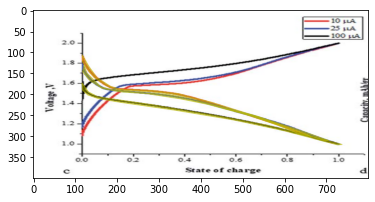

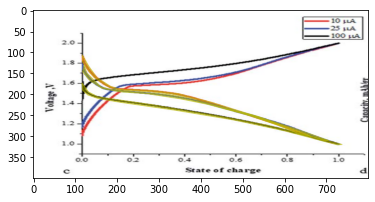

In [9]:
show_img_and_mask(imgs,polygon_list)

In [10]:
def show_img_and_mask_json(json_file):
    img, polys = json_to_arrs("DischargeCurve_annotatedexample.json")
    plt.imshow(img,alpha=1)
    mask = []
    for index,item in enumerate(polys):
        poly = item.tolist()
        poly.append(item[-1].tolist())
        x, y = zip(*poly)
        mask.append(plt.fill(x,y,alpha=0.5,color="y"))
    for index,item in enumerate(mask):
        plt.show(mask[index])

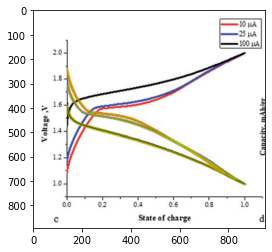

In [11]:
show_img_and_mask_json("DischargeCurve_annotatedexample.json")

In [12]:
# Crop and Pad image and mask
# Use Centerpadtofixedsize() to pad image to fixed size
# Get padded pixels imgaug and move polygon masks to corresponding positions

https://imgaug.readthedocs.io/en/latest/source/api_augmenters_size.html?highlight=padto#imgaug.augmenters.size.CenterPadToFixedSize